In [1]:
import sys
sys.path.append('/home/stratis/probabilistic-rl-thesis/code')

import os
import pathlib
import pickle

from TabularAgents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from EnvironmentsPS import DeepSea, WideNarrow, GridWall, PriorMDP

from tqdm import tqdm_notebook as tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from copy import deepcopy

from utils import solve_tabular_continuing_PI

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

In [2]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

save_loc = 'download_figures/posterior_accuracies/'
!mkdir download_figures/posterior_accuracies

mkdir: cannot create directory ‘download_figures/posterior_accuracies’: File exists


In [3]:
def run_offline_experiment(environment, pi, num_offline_frames, seed, num_oracle_iter):
    
    np.random.seed(seed)
    
    # Save current environment state
    s0, t0 = environment.s, environment.t
    
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    states, actions, rewards, states_ = [], [], [], []
    
    for n in range(num_offline_frames):
        
        a = pi[s]
        
        # Step environment
        s_, r, t, done = environment.step(a)
        
        states.append(s)
        actions.append(a)
        rewards.append(r)
        states_.append(s_)
        
        s = s_
        
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    agent_sars_ = np.array(states), np.array(actions), np.array(rewards), np.array(states_)
    
    oracle_sars_ = run_oracle_experiment(environment,
                                         seed,
                                         gamma=agent.gamma, 
                                         num_iter=num_oracle_iter,
                                         num_episodes=1,
                                         num_frames_per_episode=num_offline_frames-1)
    
    offline_regret = np.sum((oracle_sars_[2] - agent_sars_[2]))
    
    # Restore environment state
    environment.s, environment.t = s0, t0
    
    return [offline_regret, oracle_sars_, agent_sars_]

In [4]:
def run_experiment(environment,
                   agent,
                   seed,
                   num_episodes,
                   num_frames_per_episode,
                   save_every,
                   num_offline_frames,
                   num_oracle_iter,
                   max_buffer_length=0):
    
    np.random.seed(seed)
    
    # Initial state
    environment.reset()
    s, t = 0, 0

    # Save location for agent
    save_loc = '/big/tabular_results/toy-deepsea/{}/{}/seed-{}/'.format(environment.get_name(),
                                                                        agent.get_name(),
                                                                        seed)
    pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
    
    agent_copies = []
    
    for n in range(num_episodes):
        for i in tqdm(range(num_frames_per_episode + 1)):
            
            # Take action
            a = agent.take_action(s, t)

            # Step environment
            s_, r, t, done = environment.step(a)

            # Update agent
            agent.observe([t, s, a, r, s_])
            agent.update_after_step(max_buffer_length)

            # Update current state (for agent)
            s = s_
            
            if i % save_every == 0:
                agent_copies.append(deepcopy(agent))
                
                result = run_offline_experiment(environment,
                                                agent.get_greedy_policy(),
                                                num_offline_frames,
                                                np.random.randint(low=0, high=int(1e6)),
                                                num_oracle_iter)

                agent.offline_regret = result[0]
                agent.agent_sars_ = result[1]
                agent.oracle_sars_ = result[2]

                agent.save_copy(save_loc, '{}_{}'.format(n, i))
                
    return agent_copies

In [5]:
def run_oracle_experiment(environment, seed, gamma, num_iter, num_episodes, num_frames_per_episode):
    
    np.random.seed(seed * 10)
    
    # Initial state
    environment.reset()
    s, t = 0, 0
    
    pi, Q = environment.get_optimal_policy(gamma=gamma, num_iter=num_iter)

    # Save location for agent
    save_loc = '/big/tabular_results/{}/{}/'.format(environment.get_name(), agent.get_name())
    pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
    
    states, actions, rewards, states_ = [], [], [], []
    
    for n in range(num_episodes):
        for i in range(num_frames_per_episode + 1):
            
            # Take action
            a = pi[s]

            # Step environment
            s_, r, t, done = environment.step(a)

            states.append(s)
            actions.append(a)
            rewards.append(r)
            states_.append(s_)

            # Update current state (for agent)
            s = s_
        
    return np.array(states), np.array(actions), np.array(rewards), np.array(states_)

In [6]:
def load_agent(environment, agent, seed, episode, frame):

    # Load location
    load_name = '/big/tabular_results/toy-deepsea/{}/{}/seed-{}/chkpt_{}_{}'.format(environment.get_name(),
                                                                                    agent.get_name(),
                                                                                    seed,
                                                                                    episode,
                                                                                    frame)
    
    # Load the agent
    fhandle = open(load_name, 'rb')
    agent = pickle.load(fhandle)
    
    return agent

In [7]:
save_every = 40
L = 4

# QL

In [359]:
# for L in tqdm([4]):
#     for seed in tqdm(range(10)):

#         # Environment constants
#         rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
#         env_params = {'L'          :  L,
#                       'episodic'   :  False,
#                       'rew_params' :  rew_params}

#         # Define environment
#         environment = DeepSea(env_params)
#         environment.reset()

#         # Agent constants
#         agent_params = {'gamma'            : 0.9,
#                         'dither_mode'      : 'boltzmann',
#                         'dither_param'     : 0.2,
#                         'lr'               : 0.1,
#                         'Q0'               : 0.0,
#                         'T'                : float('inf'),
#                         'anneal_timescale' : float('inf'),
#                         'sa_list'          : environment.sa_list()}

#         # Define agent
#         agent = QLearningAgent(agent_params)

#         # Run experiment
#         agent_copies = run_experiment(environment,
#                                       agent,
#                                       seed=seed,
#                                       num_episodes=1,
#                                       num_frames_per_episode=4000,
#                                       num_offline_frames=1000,
#                                       num_oracle_iter=40,
#                                       save_every=save_every)

In [360]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [361]:
means, stds = [], []

means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'boltzmann',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'T'                : float('inf'),
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

# Define agent
agent = QLearningAgent(agent_params)

for frame in np.arange(0, 4001, save_every):
    
    # Define agent
    agent_ = load_agent(environment, QLearningAgent(agent_params), seed=seed, episode=0, frame=frame)
    
    means.append([])
    
    for s in range(4):
        
        means[-1].append([])
        
        for a in range(2):
            means[-1][-1].append(agent_.Q[s][a])
            
means = np.array(means)

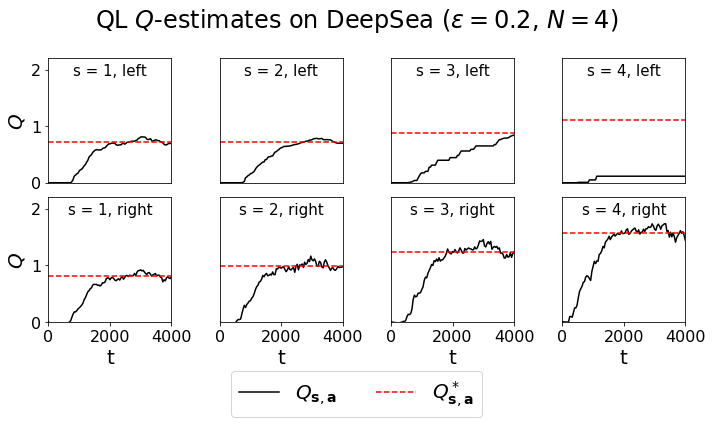

In [362]:
fig = plt.figure(figsize=(10, 6))

actions = ['left', 'right']
leg_names = ['$Q_{\mathbf{s}, \mathbf{a}}$', '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 2

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='black')
        
        leg[1], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.9, r's = {}, {}'.format(s + 1, actions[a]), fontsize=15, horizontalalignment='center')
            
        plt.ylim([0, 2.2])
            
fig.suptitle('QL $Q$-estimates on DeepSea ($\epsilon = 0.2$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'ql-posterior-accuracy-deepsea-4.pdf', bbox_inches='tight')
plt.show()

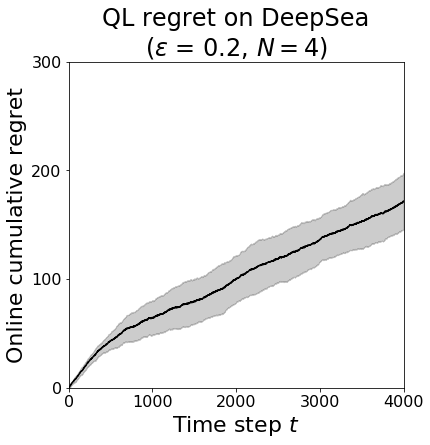

In [363]:
# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'boltzmann',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'T'                : float('inf'),
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = QLearningAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color='k')
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color='k', alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('QL regret on DeepSea\n($\epsilon$ = 0.2, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'ql-cumulative-regret-deepsea-4.pdf', bbox_inches='tight')
plt.show()

# BQL

In [16]:
for L in tqdm([4]):
    for seed in tqdm(range(10)):

        # Environment constants
        rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
        env_params = {'L'          :  L,
                      'episodic'   :  False,
                      'rew_params' :  rew_params}

        # Define environment
        environment = DeepSea(env_params)
        environment.reset()

        # Agent constants
        agent_params = {'gamma'               : 0.9,
                        'mu0'                 : 1.5,
                        'lamda'               : 1.0,
                        'alpha'               : 2.0,
                        'beta'                : 2.0,
                        'T'                   : float('inf'),
                        'num_mixture_samples' : 1000,
                        'sa_list'             : environment.sa_list()}

        # Define agent
        agent = BayesianQAgent(agent_params)

        # Run experiment
        agent_copies = run_experiment(environment,
                                      agent,
                                      seed=seed,
                                      num_episodes=1,
                                      num_frames_per_episode=4000,
                                      num_offline_frames=1000,
                                      num_oracle_iter=40,
                                      save_every=save_every)

In [17]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [18]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 1.5,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}


agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    # Define agent
    agent_ = load_agent(environment, BayesianQAgent(agent_params), seed=seed, episode=0, frame=frame)
    
    means.append([])
    stds.append([])
    
    for s in range(4):
        
        means[-1].append([])
        stds[-1].append([])
        
        for a in range(2):
            mu, lamda, alpha, beta = agent_.Qpost[s][a]
            var = beta / (lamda * (alpha - 1))
            
            means[-1][-1].append(mu)
            stds[-1][-1].append(var**0.5)
            
means, stds = np.array(means), np.array(stds)

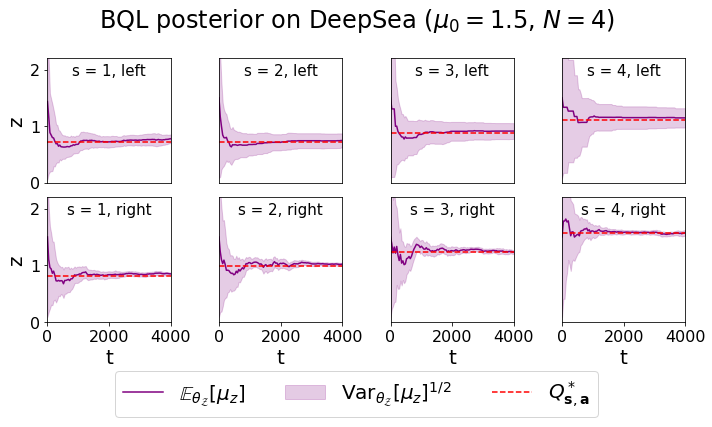

In [19]:
fig = plt.figure(figsize=(10, 6))

actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{Z}}}[\mu_z]$',
             'Var$_{\\theta_{\mathcal{Z}}}[\mu_z]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='purple')
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color='purple', alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.9, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')            
        plt.ylim([0, 2.2])
            
            
fig.suptitle('BQL posterior on DeepSea ($\mu_0 = 1.5$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'bql-posterior-accuracy-deepsea-4-1_5.pdf', bbox_inches='tight')
plt.show()

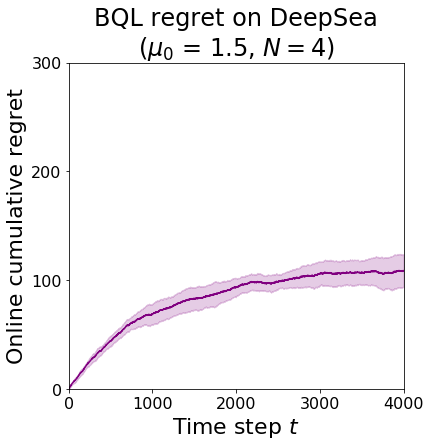

In [27]:
color = 'purple'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 1.5,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = BayesianQAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('BQL regret on DeepSea\n($\mu_0$ = 1.5, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'bql-cumulative-regret-deepsea-4-1_5.pdf', bbox_inches='tight')
plt.show()

# BQL

In [21]:
for L in tqdm([4]):
    for seed in tqdm(range(10)):

        # Environment constants
        rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
        env_params = {'L'          :  L,
                      'episodic'   :  False,
                      'rew_params' :  rew_params}

        # Define environment
        environment = DeepSea(env_params)
        environment.reset()

        # Agent constants
        agent_params = {'gamma'               : 0.9,
                        'mu0'                 : 0.0,
                        'lamda'               : 1.0,
                        'alpha'               : 2.0,
                        'beta'                : 2.0,
                        'T'                   : float('inf'),
                        'num_mixture_samples' : 1000,
                        'sa_list'             : environment.sa_list()}

        # Define agent
        agent = BayesianQAgent(agent_params)

        # Run experiment
        agent_copies = run_experiment(environment,
                                      agent,
                                      seed=seed,
                                      num_episodes=1,
                                      num_frames_per_episode=4000,
                                      num_offline_frames=1000,
                                      num_oracle_iter=40,
                                      save_every=save_every)

In [22]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

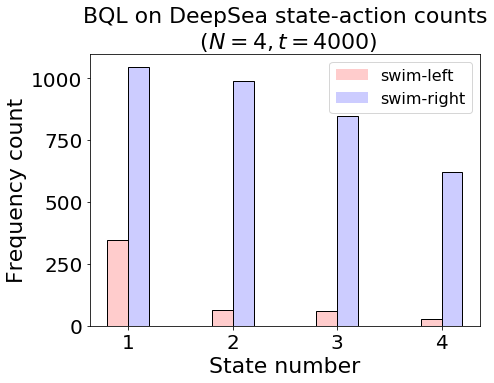

In [57]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}


agent_rs, oracle_rs = [], []
    
frame = 4000

# Define agent
agent_ = load_agent(environment, BayesianQAgent(agent_params), seed=seed, episode=0, frame=frame)

counts = np.zeros((4, 2))
for s, a in zip(agent_.train_s, agent_.train_a):
    counts[s, a] += 1
    
x = np.array([1., 2., 3., 4.])

a1 = counts[:, 0]
a2 = counts[:, 1]

plt.figure(figsize=(7, 5))
ax = plt.subplot(111)
ax.bar(x-0.1, a1, width=0.2, color='b', align='center', facecolor="red", alpha=0.2, label='swim-left')
ax.bar(x-0.1, a1, width=0.2, color='b', align='center', facecolor="None", edgecolor='k')
ax.bar(x+0.1, a2, width=0.2, color='g', align='center', facecolor="blue", alpha=0.2, label='swim-right')
ax.bar(x+0.1, a2, width=0.2, color='g', align='center', facecolor="None", edgecolor='k')

plt.xticks([1, 2, 3, 4], fontsize=20)
plt.yticks([0, 250, 500, 750, 1000], fontsize=20)
# plt.yticks([0, 25, 50, 75, 100], fontsize=20)
plt.xlabel('State number', fontsize=22)
plt.ylabel('Frequency count', fontsize=22)
plt.title('BQL on DeepSea state-action counts\n $(N = 4, t = {})$'.format(frame), fontsize=22)
plt.legend(loc='upper right')
plt.savefig(save_loc + '/bql-state-action-4000.pdf', bbox_inches='tight')
plt.show()

In [23]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}


agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    # Define agent
    agent_ = load_agent(environment, BayesianQAgent(agent_params), seed=seed, episode=0, frame=frame)
    
    means.append([])
    stds.append([])
    
    for s in range(4):
        
        means[-1].append([])
        stds[-1].append([])
        
        for a in range(2):
            mu, lamda, alpha, beta = agent_.Qpost[s][a]
            var = beta / (lamda * (alpha - 1))
            
            means[-1][-1].append(mu)
            stds[-1][-1].append(var**0.5)
            
means, stds = np.array(means), np.array(stds)

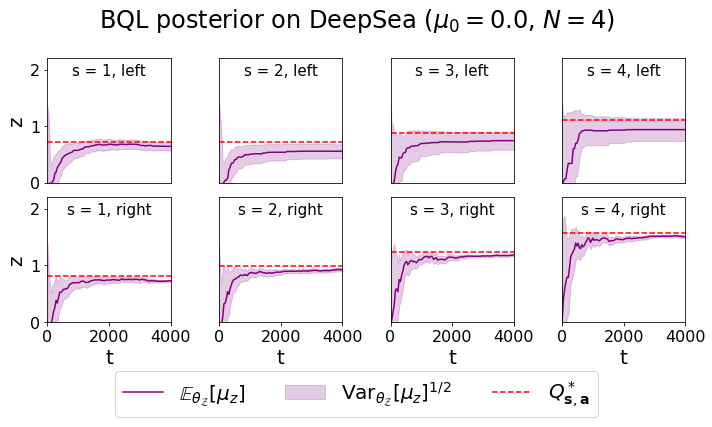

In [24]:
fig = plt.figure(figsize=(10, 6))

actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{Z}}}[\mu_z]$',
             'Var$_{\\theta_{\mathcal{Z}}}[\mu_z]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color='purple')
        
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color='purple', alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.9, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')            
        plt.ylim([0, 2.2])
            
            
fig.suptitle('BQL posterior on DeepSea ($\mu_0 = 0.0$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'bql-posterior-accuracy-deepsea-4-misspecified-0_0.pdf', bbox_inches='tight')
plt.show()

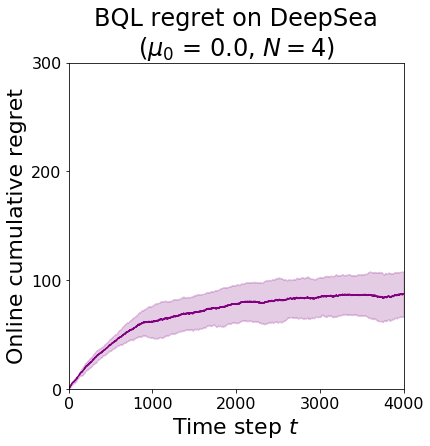

In [26]:
color = 'purple'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'T'                   : float('inf'),
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = BayesianQAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('BQL regret on DeepSea\n($\mu_0$ = 0.0, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'bql-cumulative-regret-deepsea-4-0_0.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [374]:
# for L in tqdm([4]):
#     for seed in tqdm(range(10)):

#         # Environment constants
#         rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
#         env_params = {'L'          :  L,
#                       'episodic'   :  False,
#                       'rew_params' :  rew_params}

#         # Define environment
#         environment = DeepSea(env_params)
#         environment.reset()

#         # Agent constants
#         agent_params = {'gamma'            : 0.9,
#                         'kappa'            : 1.0,
#                         'mu0'              : 0.0,
#                         'lamda'            : 1.0,
#                         'alpha'            : 2.0,
#                         'beta'             : 2.0,
#                         'num_pi_iter'      : 40,
#                         'T'                : float('inf'),
#                         'num_dyn_samples'  : 100,
#                         'sa_list'          : environment.sa_list()}

#         # Define agent
#         agent = PSRLAgent(agent_params)

#         # Run experiment
#         agent_copies = run_experiment(environment,
#                                       agent,
#                                       seed=seed,
#                                       num_episodes=1,
#                                       num_frames_per_episode=4000,
#                                       num_offline_frames=1000,
#                                       num_oracle_iter=40,
#                                       max_buffer_length=L,
#                                       save_every=save_every)

In [404]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [409]:
means = []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

for frame in np.arange(0, 4001, 40):
    
    agent_ = load_agent(environment, PSRLAgent(agent_params), seed=0, episode=0, frame=frame)
          
    means.append([])
    
    for i in range(20):
        P, R = agent_.sample_posterior()
        pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=50)
        means[-1].append(Q_)
            
means = np.array(means)
print(means.shape)
stds = np.var(means, axis=1)**0.5
means = np.mean(means, axis=1)
print(means.shape)

(101, 20, 4, 2)
(101, 4, 2)


In [410]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

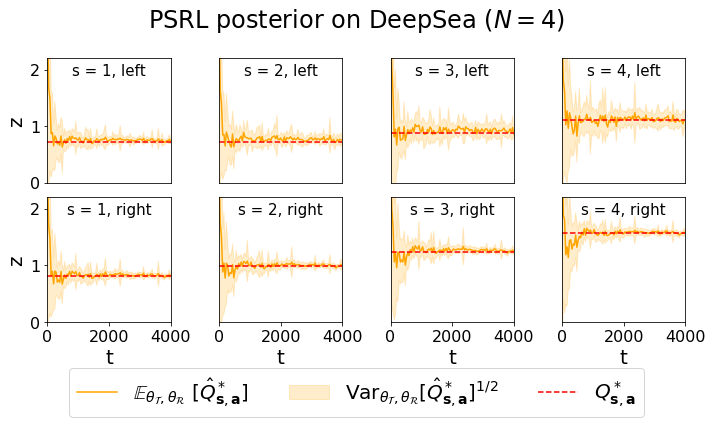

In [411]:
fig = plt.figure(figsize=(10, 6))

color = 'orange'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}~[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.9, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')            
        plt.ylim([0, 2.2])
            
            
fig.suptitle('PSRL posterior on DeepSea ($N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'psrl-posterior-accuracy-deepsea-4.pdf', bbox_inches='tight')
plt.show()

In [110]:
means = []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_ = load_agent(environment, PSRLAgent(agent_params), seed=0, episode=0, frame=4000)


for i in range(1000):
    P, R = agent_.sample_posterior()
    pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=50)
    means.append(Q_)
    
means = np.array(means)

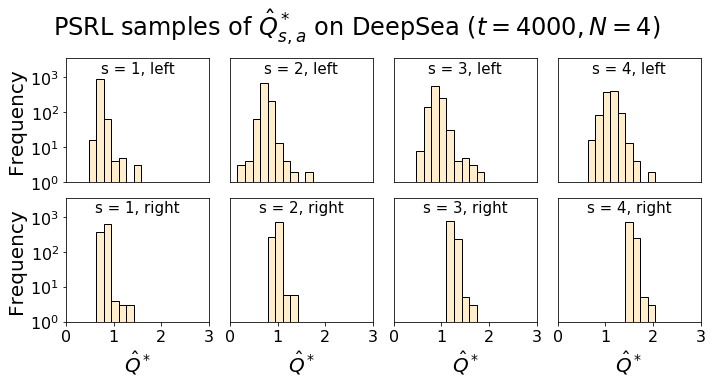

In [111]:
fig = plt.figure(figsize=(10, 6))

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        
        plt.hist(means[:, s, a],
                 facecolor="orange",
                 alpha=0.2,
                 log=True,
                 bins=np.linspace(0, 3.0, 20))
        
        plt.hist(means[:, s, a],
                 facecolor="None",
                 edgecolor='k',
                 bins=np.linspace(0, 3.0, 20))
        
        plt.xticks([0.0, 1.0, 2.0, 3.0])
        plt.yticks([1e0, 1e1, 1e2, 1e3])
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('Frequency', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('$\hat{Q}^*$', fontsize=20)
            
        plt.xlim([0, 3.0])
        plt.ylim([1e0, 3500])
        plt.gca().text(1.5, 1800, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center', verticalalignment='center')  
        plt.tight_layout()
        
fig.suptitle('PSRL samples of $\hat{Q}^*_{s, a}$ on DeepSea ($t = 4000, N = 4$)', fontsize=24)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'psrl-q-samples-deepsea-4000.pdf', bbox_inches='tight')
plt.show()

In [144]:
kappa = np.array([1., 1., 100., 10000.])

samples = np.random.dirichlet(kappa, size=100000)
(samples.var(axis=0) / samples.mean(axis=0)).sum() * 100 * 10

0.29988782926461627

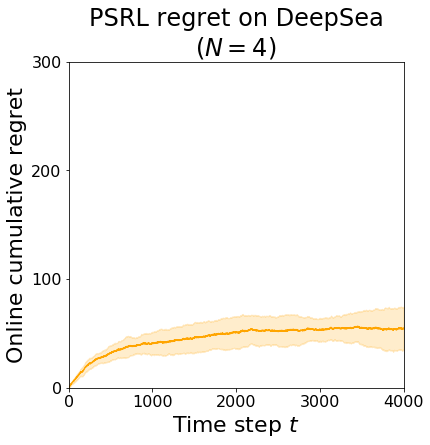

In [412]:
color = 'orange'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = PSRLAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('PSRL regret on DeepSea\n($N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'psrl-cumulative-regret-deepsea-4.pdf', bbox_inches='tight')
plt.show()

# UBE

In [380]:
# for L in tqdm([4]):
#     for seed in tqdm(range(10)):

#         # Environment constants
#         rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
#         env_params = {'L'          :  L,
#                       'episodic'   :  False,
#                       'rew_params' :  rew_params}

#         # Define environment
#         environment = DeepSea(env_params)
#         environment.reset()
        
#         # Agent constants
#         agent_params = {'gamma'            : 0.9,
#                         'kappa'            : 1.0,
#                         'mu0'              : 0.0,
#                         'lamda'            : 1.0,
#                         'alpha'            : 2.0,
#                         'beta'             : 2.0,
#                         'Rmax'             : 1.0,
#                         'num_pi_iter'      : 40,
#                         'T'                : float('inf'),
#                         'zeta'             : 1.0,
#                         'num_dyn_samples'  : 100,
#                         'sa_list'          : environment.sa_list()}


#         # Define agent
#         agent = UbeNoUnrollAgent(agent_params)

#         # Run experiment
#         agent_copies = run_experiment(environment,
#                                       agent,
#                                       seed=seed,
#                                       num_episodes=1,
#                                       num_frames_per_episode=4000,
#                                       num_offline_frames=1000,
#                                       num_oracle_iter=40,
#                                       max_buffer_length=L,
#                                       save_every=1000)

In [381]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [152]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 1.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    agent_ = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.Qmu)
    stds.append(agent_.Qvar**0.5)
            
means = np.array(means)
stds = np.array(stds)

[[0.0144105  0.01206352]
 [0.02592277 0.0196381 ]
 [0.04988848 0.03678756]
 [0.10415102 0.09320977]]
[[0.24746558 0.27513094]
 [0.51905346 0.55988409]
 [0.9435131  0.94247718]
 [2.21638361 2.14360628]]


KeyboardInterrupt: 

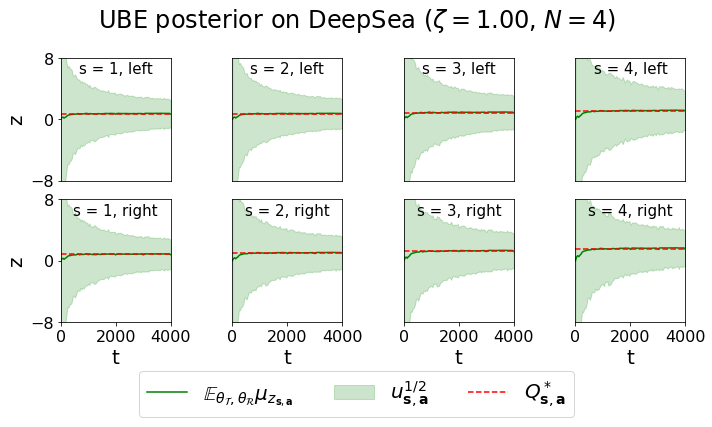

In [383]:
fig = plt.figure(figsize=(10, 6))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}\mu_{z_{\mathbf{s}, \mathbf{a}}}$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']

leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([-8, 8])
        plt.yticks([-8, 0, 8])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 6, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')          
            
            
fig.suptitle('UBE posterior on DeepSea ($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'ube-posterior-accuracy-deepsea-4-1_00.pdf', bbox_inches='tight')
plt.show()

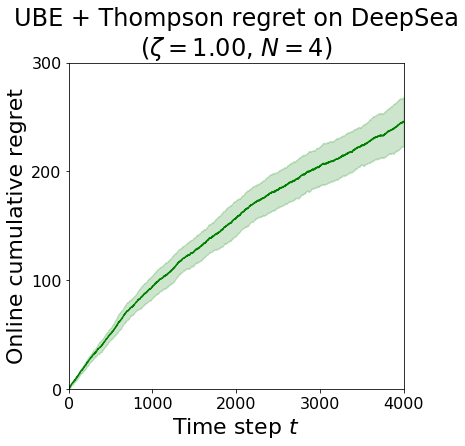

In [384]:
color = 'green'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 1.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = UbeNoUnrollAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE + Thompson regret on DeepSea\n($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'ube-cumulative-regret-deepsea-4-1_00.pdf', bbox_inches='tight')
plt.show()

In [ ]:
agent_ = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0, episode=0, frame=4000)

var_rew, var_Qmax = agent.local_rew_var(agent.sample_dynamics())

x = np.arange(4) + 1

fig = plt.figure(figsize=(11, 5))

for a in range(2):
    
    plt.subplot(2, 1, a + 1)
    
    plt.bar(x-0.1, var_rew[:, a], width=0.2, color='b', align='center',
           facecolor="darkolivegreen", alpha=0.2, label='Rew. epistemic variance')
    plt.bar(x-0.1, var_rew[:, a], width=0.2, color='b', align='center',
           facecolor="None", edgecolor='k')
    plt.bar(x+0.1, var_Qmax[:, a], width=0.2, color='g', align='center',
           facecolor="c", alpha=0.2, label='$Q_{max}$ term')
    plt.bar(x+0.1, var_Qmax[:, a], width=0.2, color='g', align='center',
           facecolor="None", edgecolor='k')

    if a == 1:
        plt.xticks([1, 2, 3, 4])
        plt.xlabel('State', fontsize=20)
    else:
        plt.title('UBE local uncertainty terms on DeepSea ($t = 4000, N = 4$)', fontsize=24)
        plt.xticks([])
    plt.yticks([0, 1, 2])
    plt.ylabel('Variance', fontsize=20)
    plt.legend(loc='upper left')
    #plt.gca().text(1.5, 0, r's = {}, {}'.format(s + 1, actions[a]),
    #               fontsize=15, horizontalalignment='center', verticalalignment='center')  
    plt.tight_layout()
plt.savefig(save_loc + 'ube-local-variance-decomp-4000.pdf', bbox_inches='tight')
plt.show()

# UBE

In [385]:
# for L in tqdm([4]):
#     for seed in tqdm(range(10)):

#         # Environment constants
#         rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
#         env_params = {'L'          :  L,
#                       'episodic'   :  False,
#                       'rew_params' :  rew_params}

#         # Define environment
#         environment = DeepSea(env_params)
#         environment.reset()

#         # Agent constants
#         agent_params = {'gamma'            : 0.9,
#                         'kappa'            : 1.0,
#                         'mu0'              : 0.0,
#                         'lamda'            : 1.0,
#                         'alpha'            : 2.0,
#                         'beta'             : 2.0,
#                         'Rmax'             : 1.0,
#                         'num_pi_iter'      : 40,
#                         'T'                : float('inf'),
#                         'zeta'             : 0.1,
#                         'num_dyn_samples'  : 100,
#                         'sa_list'          : environment.sa_list()}


#         # Define agent
#         agent = UbeNoUnrollAgent(agent_params)

#         # Run experiment
#         agent_copies = run_experiment(environment,
#                                       agent,
#                                       seed=seed,
#                                       num_episodes=1,
#                                       num_frames_per_episode=4000,
#                                       num_offline_frames=100,
#                                       num_oracle_iter=40,
#                                       max_buffer_length=L,
#                                       save_every=save_every)

In [386]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [387]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 1.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    agent_ = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.Qmu)
    stds.append(agent_.Qvar**0.5)
            
means = np.array(means)
stds = np.array(stds)

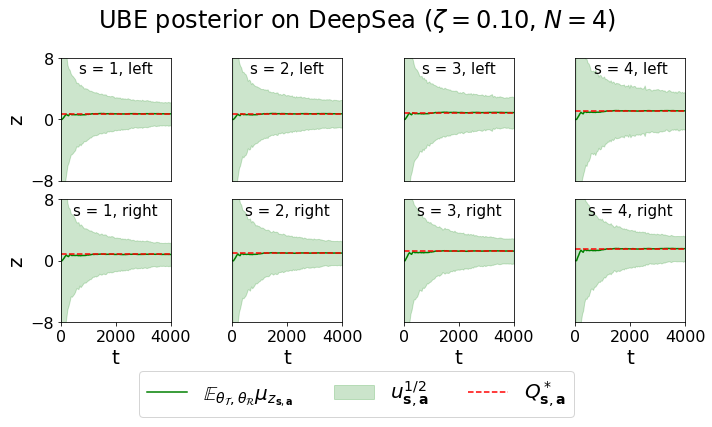

In [388]:
fig = plt.figure(figsize=(10, 6))
subsample = 20

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}\mu_{z_{\mathbf{s}, \mathbf{a}}}$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([-8, 8])
        plt.yticks([-8, 0, 8])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 6, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')          
            
            
fig.suptitle('UBE posterior on DeepSea ($\zeta = 0.10$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'ube-posterior-accuracy-deepsea-4-0_10.pdf', bbox_inches='tight')
plt.show()

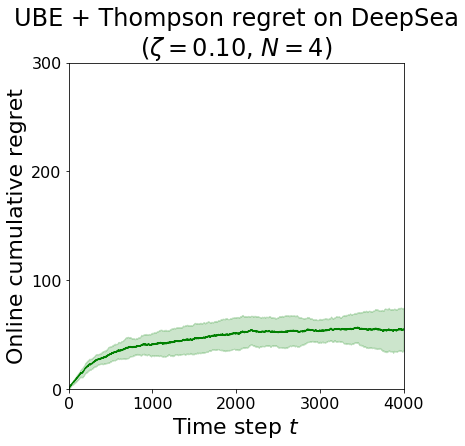

In [389]:
color = 'green'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : 1.0,
                'num_pi_iter'      : 40,
                'T'                : float('inf'),
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = PSRLAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE + Thompson regret on DeepSea\n($\zeta = 0.10$, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'ube-cumulative-regret-deepsea-4-0_10.pdf', bbox_inches='tight')
plt.show()

# MM Variance bonuus

In [122]:
for L in tqdm([4]):
    for seed in tqdm(range(1)):

        # Environment constants
        rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
        env_params = {'L'          :  L,
                      'episodic'   :  False,
                      'rew_params' :  rew_params}

        # Define environment
        environment = DeepSea(env_params)
        environment.reset()

        # Agent constants
        agent_params = {'gamma'            : 0.9,
                        'kappa'            : 1.0,
                        'mu0'              : 0.0,
                        'lamda'            : 1.0,
                        'alpha'            : 2.0,
                        'beta'             : 2.0,
                        'num_PI_steps'     : 40,
                        'T'                : float('inf'),
                        'zeta'             : 1.0,
                        'thompson'         : False,
                        'num_dyn_samples'  : 100, 
                        'sa_list'          : environment.sa_list()}

        # Define agent
        agent = MomentMatchingAgent(agent_params)

        # Run experiment
        agent_copies = run_experiment(environment,
                                      agent,
                                      seed=seed,
                                      num_episodes=1,
                                      num_frames_per_episode=4000,
                                      num_offline_frames=100,
                                      num_oracle_iter=40,
                                      max_buffer_length=L,
                                      save_every=save_every)

In [123]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [124]:
means, stds = [], []

means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : False,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    agent_ = load_agent(environment, MomentMatchingAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.mu_z_sa)
    stds.append(agent_.val_var_val)
            
means = np.array(means)
stds = np.array(stds)

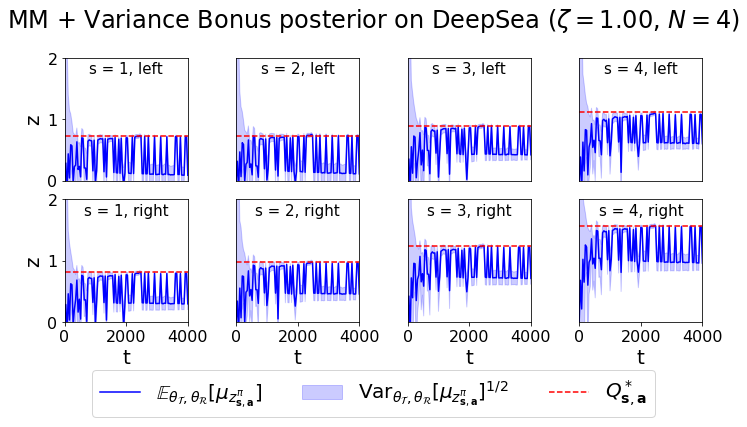

In [125]:
fig = plt.figure(figsize=(10, 6))
subsample = 20

color = 'blue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^\pi_{\mathbf{s}, \mathbf{a}}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^\pi_{\mathbf{s}, \mathbf{a}}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.75, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')          
            
            
fig.suptitle('MM + Variance Bonus posterior on DeepSea ($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
kappa, mu, lamda, alpha, beta = agent_.kappa, agent_.mu0, agent_.lamda, agent_.alpha, agent_.beta
plt.savefig(save_loc + 'mm-ucb-posterior-accuracy-deepsea-4-{}-{}-{}-{}={}.pdf'.format(kappa, mu, lamda, alpha, beta),
            bbox_inches='tight')
plt.show()

In [112]:
stds[90:].max()

0.1481271709335155

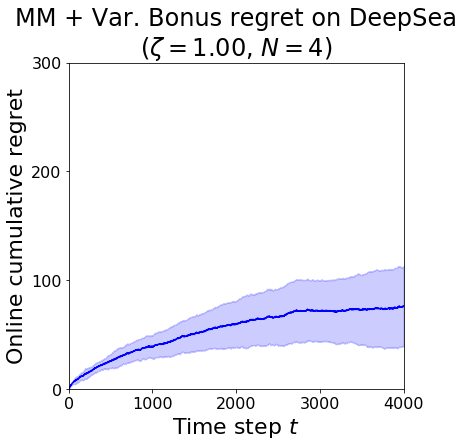

In [113]:
color = 'blue'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : False,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = MomentMatchingAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM + Var. Bonus regret on DeepSea\n($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=300)
plt.savefig(save_loc + 'mm-ucb-cumulative-regret-deepsea-4-1_00.pdf', bbox_inches='tight')
plt.show()

# MM Thompson

In [8]:
save_every = 40

In [93]:
for L in tqdm([4]):
    for seed in tqdm(range(1)):

        # Environment constants
        rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
        env_params = {'L'          :  L,
                      'episodic'   :  False,
                      'rew_params' :  rew_params}

        # Define environment
        environment = DeepSea(env_params)
        environment.reset()

        # Agent constants
        agent_params = {'gamma'            : 0.9,
                        'kappa'            : 0.5,
                        'mu0'              : 0.0,
                        'lamda'            : 4.0,
                        'alpha'            : 4.0,
                        'beta'             : 4.0,
                        'num_PI_steps'     : 40,
                        'T'                : float('inf'),
                        'zeta'             : 1.0,
                        'thompson'         : True,
                        'num_dyn_samples'  : 100, 
                        'sa_list'          : environment.sa_list()}

        # Define agent
        agent = MomentMatchingAgent(agent_params)

        # Run experiment
        agent_copies = run_experiment(environment,
                                      agent,
                                      seed=seed,
                                      num_episodes=1,
                                      num_frames_per_episode=4000,
                                      num_offline_frames=100,
                                      num_oracle_iter=40,
                                      max_buffer_length=L,
                                      save_every=save_every)

In [94]:
P, R = environment.get_P_and_R()

pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, num_iter=100)

In [95]:
means, stds = [], []

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 0.5,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 4.0,
                'beta'             : 4.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : True,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

agent_rs, oracle_rs = [], []

for frame in np.arange(0, 4001, save_every):
    
    agent_ = load_agent(environment, MomentMatchingAgent(agent_params), seed=0, episode=0, frame=frame)
            
    means.append(agent_.mu_z_sa)
    stds.append(agent_.val_var_val**0.5)
            
means = np.array(means)
stds = np.array(stds)

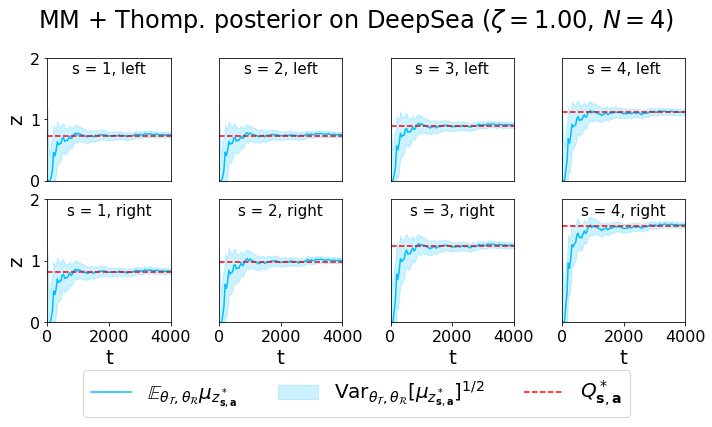

In [96]:
fig = plt.figure(figsize=(10, 6))

color = 'deepskyblue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}\mu_{z^*_{\mathbf{s}, \mathbf{a}}}$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^*_{\mathbf{s}, \mathbf{a}}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(4):
    for a in range(2):
        
        plt.subplot(2, 4, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([0, 2])
        plt.yticks([0, 1, 2])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, 2000, 4000])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('z', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.gca().text(2000, 1.75, r's = {}, {}'.format(s + 1, actions[a]),
                       fontsize=15, horizontalalignment='center')          
            
            
fig.suptitle('MM + Thomp. posterior on DeepSea ($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)
plt.savefig(save_loc + 'mm-thompson-posterior-accuracy-deepsea-4.pdf', bbox_inches='tight')
plt.show()

In [97]:
stds[-1, 0, 1]

0.04489868844601272

In [98]:
means[-1, 0, 0]

0.7466187712292475

In [99]:
agent_.val_var_val[0, 1]

0.0020158922241721162

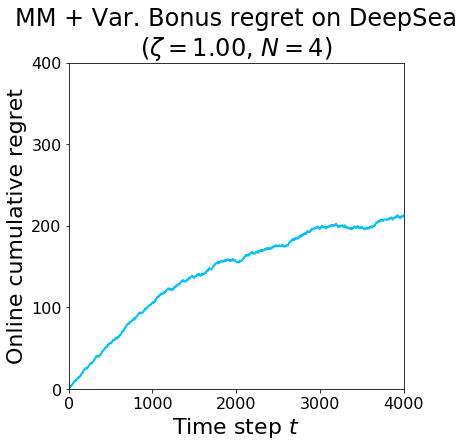

In [100]:
color = 'deepskyblue'

# Environment constants
rew_params = ((0., 0.), (-1e-1 * np.exp(- L / 4), 0.), (1., 0.))
env_params = {'L'          :  L,
              'episodic'   :  False,
              'rew_params' :  rew_params}

# Define environment
environment = DeepSea(env_params)
environment.reset()

# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 2.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'num_PI_steps'     : 40,
                'T'                : float('inf'),
                'zeta'             : 1.0,
                'thompson'         : True,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}


agent_rs, oracle_rs = [], []

for seed in range(1):
    
    # Define agent
    agent = MomentMatchingAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed, episode=0, frame=4000)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_iter=40,
                                     num_episodes=1,
                                     num_frames_per_episode=4000)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM + Var. Bonus regret on DeepSea\n($\zeta = 1.00$, $N = 4$)', fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Online cumulative regret', fontsize=22)
plt.xlim([0, 4000])
plt.gca().set_ylim(bottom=0, top=400)
# plt.savefig(save_loc + 'mm-thompson-cumulative-regret-deepsea-4.pdf', bbox_inches='tight')
plt.show()

In [101]:
agent_ = load_agent(environment, agent, seed=seed, episode=0, frame=4000)

In [102]:
agent_.val_var_val**0.5 / agent_.gamma

array([[0.10363749, 0.1071836 ],
       [0.10368981, 0.11054751],
       [0.10834813, 0.11102743],
       [0.11269701, 0.10638245]])

In [103]:
agent_.mu_z_sa

array([[0.67216416, 0.74494462],
       [0.67491409, 0.90687989],
       [0.8223824 , 1.16004993],
       [1.03867737, 1.4758661 ]])

In [104]:
print(agent_.rew_var_dyn)
print(agent_.rew_var_rew)
print(agent_.cov_rew_val)
print(agent_.val_var_dyn)
print(agent_.val_var_val)

[[0.00000000e+00 1.68765269e-09]
 [0.00000000e+00 2.34589105e-09]
 [0.00000000e+00 7.99072501e-09]
 [0.00000000e+00 4.43213866e-04]]
[[0.00322911 0.00142445]
 [0.00844254 0.00179834]
 [0.02131982 0.00269603]
 [0.0555554  0.00319152]]
[[ 0.00000000e+00  4.31523113e-08]
 [ 0.00000000e+00 -7.93504279e-09]
 [ 0.00000000e+00 -1.81982668e-07]
 [ 0.00000000e+00 -3.27563129e-04]]
[[9.47694011e-07 3.77455836e-06]
 [8.95672860e-06 3.05195589e-05]
 [2.76648001e-05 9.06623932e-05]
 [1.77876789e-04 6.11975747e-05]]
[[0.00869999 0.00930554]
 [0.00870878 0.00989881]
 [0.00950885 0.00998494]
 [0.0102875  0.00916695]]


In [105]:
np.array([agent_.take_action(0, 0) for i in range(1000)]).mean()

0.698

In [106]:
pi = agent_.pi

P = agent_.sample_dynamics()

rew_params = agent_.reward_posterior_arrays()

s_idx = np.arange(len(pi))
result = agent_.var_z(P, pi, agent_.mu_z_sa[s_idx, pi], rew_params, show=True)
var_rew_dyn, var_rew_rew, cov, var_z_dyn, total_var, P_ = result

var_rew_dyn
 [[0.00000000e+00 3.41247142e-09]
 [0.00000000e+00 2.37506284e-09]
 [0.00000000e+00 4.56134707e-09]
 [0.00000000e+00 4.87578718e-04]]
var_rew_rew
 [[0.00318827 0.00144783]
 [0.0085714  0.00166368]
 [0.02156467 0.0021246 ]
 [0.05501092 0.00360638]]
cov
 [[ 0.00000000e+00  3.92549473e-08]
 [ 0.00000000e+00  3.43487453e-08]
 [ 0.00000000e+00 -2.07789558e-07]
 [ 0.00000000e+00 -1.96488494e-04]]
var_z_dyn
 [[1.27611548e-06 5.19111814e-06]
 [9.04042146e-06 4.21544885e-05]
 [2.67530190e-05 1.03018211e-04]
 [2.36788304e-04 7.99916755e-05]]
var_z
 [0.01026339 0.01107058 0.01205425 0.01253481]
0.3502452022564722 (1.0, -1.0491217919131661)


In [107]:
mu, lamda, alpha, beta = agent_.reward_posterior_arrays()

In [21]:
np.linalg.det(np.eye(P_.shape[0]) - 0.9**2 * P_)

0.3593016763604801

In [29]:
np.linalg.slogdet(np.eye(2) * 2)

(1.0, 1.3862943611198906)